In [9]:
import pdf2image
import layoutparser as lp
import PIL
from PIL import Image
import numpy as np
import cv2

In [2]:
test_path = "data/Testing (1).pdf"

In [3]:
image = pdf2image.convert_from_bytes(open(test_path, 'rb').read())

In [4]:
image

[<PIL.PpmImagePlugin.PpmImageFile image mode=RGB size=1654x2339>]

In [5]:
image = np.array(image[0])

In [40]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config', 
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.7],
                                 label_map={0: "Text", 1: "Title", 2: "List", 3:"Table", 4:"Figure"})


In [43]:
# Detect the layout of the input image
layout = model.detect(image)
layout

Layout(_blocks=[TextBlock(block=Rectangle(x_1=194.77362060546875, y_1=197.411865234375, x_2=1135.5499267578125, y_2=931.2032470703125), text=None, id=None, type=Figure, parent=None, next=None, score=0.8983482718467712), TextBlock(block=Rectangle(x_1=195.97019958496094, y_1=1033.99755859375, x_2=528.891845703125, y_2=1079.6903076171875), text=None, id=None, type=Title, parent=None, next=None, score=0.7591448426246643)], page_data={})

In [47]:
layout.to_dataframe()

,x_1,y_1,x_2,y_2,block_type,type,score
0,194.773621,197.411865,1135.549927,931.203247,rectangle,Figure,0.898348
1,195.970200,1033.997559,528.891846,1079.690308,rectangle,Title,0.759145


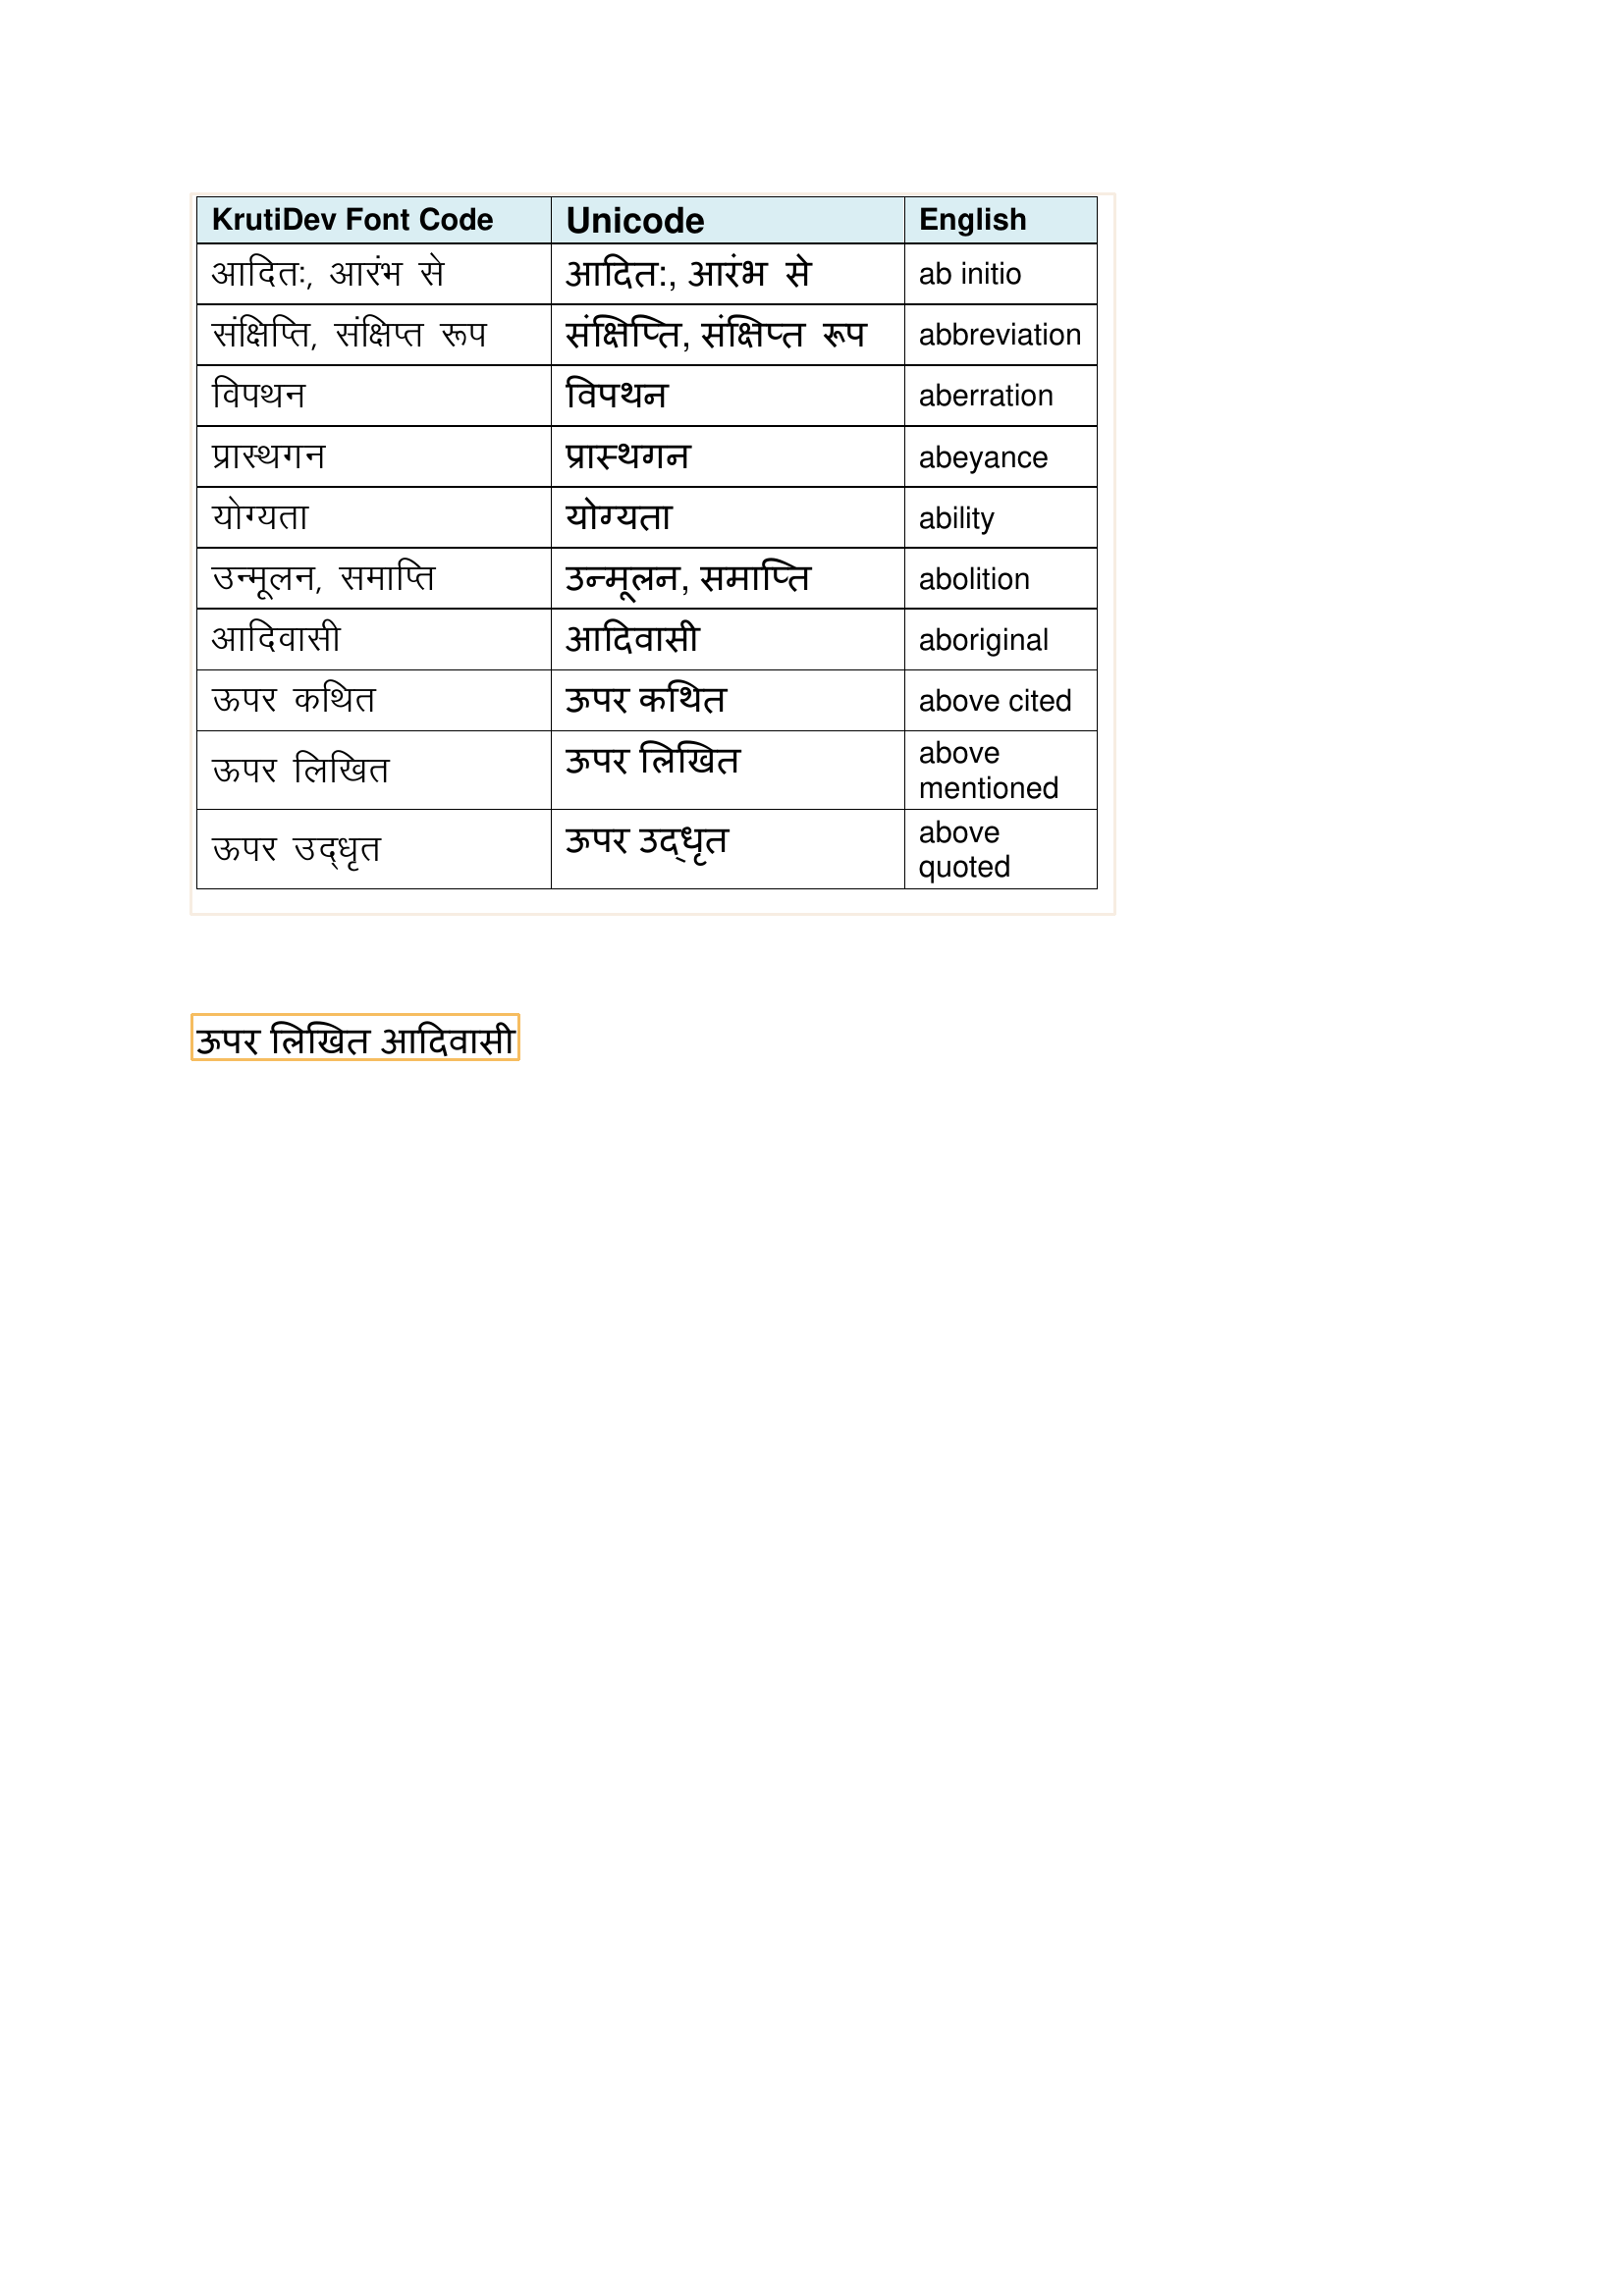

In [44]:
lp.draw_box(image, layout, box_width=3)

In [54]:
text_blocks = lp.Layout([b for b in layout if b.type=='Text'])
title_blocks = lp.Layout([b for b in layout if b.type=='Title'])
figure_blocks = lp.Layout([b for b in layout if b.type=='Figure'])

In [61]:
figure_blocks.to_dataframe()

,x_1,y_1,x_2,y_2,block_type,type,score
0,194.773621,197.411865,1135.549927,931.203247,rectangle,Figure,0.898348


In [63]:
text_blocks = lp.Layout([b for b in text_blocks \
                   if not any(b.is_in(b_fig) for b_fig in figure_blocks)])

In [64]:
text_blocks

Layout(_blocks=[], page_data={})

In [65]:
h, w = image.shape[:2]

left_interval = lp.Interval(0, w/2*1.05, axis='x').put_on_canvas(image)

left_blocks = text_blocks.filter_by(left_interval, center=True)
left_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)
# The b.coordinates[1] corresponds to the y coordinate of the region
# sort based on that can simulate the top-to-bottom reading order 
right_blocks = lp.Layout([b for b in text_blocks if b not in left_blocks])
right_blocks.sort(key = lambda b:b.coordinates[1], inplace=True)

# And finally combine the two lists and add the index
text_blocks = lp.Layout([b.set(id = idx) for idx, b in enumerate(left_blocks + right_blocks)])